#Ejercicio 10: DQN

Comencemos importando lo necesario

In [ ]:
!pip install -U gymnasium pygame moviepy
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects


In [ ]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from collections import deque

import gymnasium as gym
print("gym version:", gym.__version__)

import pygame
from moviepy.editor import ImageSequenceClip, ipython_display

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.

    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

def running_average(x, N):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

gym version: 0.29.1


Vamos a usar el problema de balancear la barra que puede ser cargado con:

gym.make('CartPole-v0')

Los estados tiene 4 valores continuos (posición y velocidad del carro, ángulo y nvelocidad de la barra) y 2 salidas discretas (mover hacia la izquierda y la derecha). La recompensa es +1 por cada transición en que la barra se mantiene en pie (angulo de 30° o menos con respecto al vertical).

En CartPole-v0, el episodio termina cuando se cae la barra o después de 200 pasos. En CartPole-v1, el máximo de pasos por episodio es 500, que por ahora es el muy alto por nosotros.

El máximo retorno sin descuentos es entonces 200.

  logger.deprecation(



Return: 11.0
MoviePy - Building file videos/cartpole.gif with imageio.



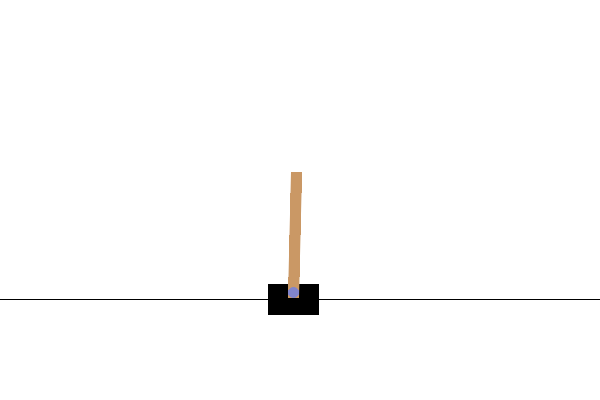

In [ ]:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action randomly
    action = env.action_space.sample()

    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward

    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole.gif"
recorder.make_video(video)
ipython_display(video)

Necesitamos dos redes, una red de entrenamiento y una red de objetivo. Creemos un metodo que retorna como modelo compilado. Este deberá ser llamado dos veces.



In [ ]:
def create_model(env, lr):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Input(env.observation_space.shape))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(env.action_space.n, activation='linear'))

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    print(model.summary())

    return model

**Importante**: cada vez que llamas a create_model, una nueva red neuronal es creada pero las anteriores no seran borradas. Durante este ejercicio crearemos cientos de redes: todas estas redes se crearán en RAM, y colab puede pegarse. Antes de crear nuevas redes puede borrar las anteriores con:

tf.keras.backend.clear_session()

**Pregunta 1:** Cree la red de entrenamiento y la red de objetivo. Cree una instancia del entorno e imprima la salida de ambas redes para el estado inicial(state, info = env.reset()). ¿Son iguales?

Sugerencia: model.predict(X, verbose=0) recibe un arreglo X de tamaño (N, 4), con N el numero de ejemplos. Aqui solo tenemos un ejemplo, asique asegurese que la entrada tenga tamaño (1, 4).

In [ ]:
env = gym.make('CartPole-v0')

state, info = env.reset()
state = state.reshape((1, env.observation_space.shape[0]))
print("State:", state)

tf.keras.backend.clear_session()
trained_model = create_model(env, 0.001)
target_model = create_model(env, 0.001)

trained_prediction = trained_model.predict(state, verbose=0)[0]
target_prediction = target_model.predict(state, verbose=0)[0]

print('-'*10)
print("Estado:", state)
print("Predicccion de la red entrenada:", trained_prediction)
print("Prediccion de la red objetivo:", target_prediction)
print('-'*10)

State: [[0.00779159 0.01814016 0.0359838  0.0103946 ]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4610 (18.01 KB)
Trainable params: 4610 (18.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320       
      

**Pregunta 2:** Transfiera los pesos del modelo de entrenamiento al modelo objetivo. Compare las predicciones.

Sugerencia: puede user w = model.get_weights() y model.set_weights(w)



In [ ]:
target_model.set_weights(trained_model.get_weights())

trained_prediction = trained_model.predict(state, verbose=0)[0]
target_prediction = target_model.predict(state, verbose=0)[0]

print('-'*10)
print("Estado:", state)
print("Predicccion de la red entrenada:", trained_prediction)
print("Prediccion de la red objetivo:", target_prediction)
print('-'*10)



----------
Estado: [[-0.04533527 -0.04978243  0.00808117 -0.03380355]]
Predicccion de la red entrenada: [0.00535707 0.00666851]
Prediccion de la red objetivo: [0.00535707 0.00666851]
----------


También necesitamos una memoria de transiciones. Usaremos un contenedor como una lista donde podremos agregar transiciones (s, a, r, s’, done) pero con una capacidad máxima. Cuando ya existen CC transiciones en la lista se debe dejar de agregar a la lista y en vez comenzar a escribir al principio de la lista.

Aquí hay una implementación básica de la memoria que necesitamos usando "double-ended queues (deque)". Una deque es una lista con una capacidad máxima.

In [ ]:
class ReplayBuffer:
    def __init__(self, max_capacity):
        self.max_capacity = max_capacity

        # deques, uno por cada elemento
        self.states = deque(maxlen=max_capacity)
        self.actions = deque(maxlen=max_capacity)
        self.rewards = deque(maxlen=max_capacity)
        self.next_states = deque(maxlen=max_capacity)
        self.dones = deque(maxlen=max_capacity)

    def append(self, state, action, reward, next_state, done):
        # Almacenar una transicion
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

    def sample(self, batch_size):
        # No retorne muestras hasta que tengamos 2*batch_size transiciones
        if len(self.states) < 2*batch_size:
            return []

        # Generar indices aleatorios.
        indices = sorted(np.random.choice(np.arange(len(self.states)), batch_size, replace=False))


        return [np.array([self.states[i] for i in indices]),
                np.array([self.actions[i] for i in indices]),
                np.array([self.rewards[i] for i in indices]),
                np.array([self.next_states[i] for i in indices]),
                np.array([self.dones[i] for i in indices])]

**Pregunta 3:** Ejecute un agente aleatorio en el entorno Cartpole (sin visualizacion) por algunos episodios y agregue cada transicion a un buffer con capacidad pequeña (e.g. 100). Genera muestras para revisar que todo funcione bien.

In [ ]:
env = gym.make('CartPole-v0')

buffer = ReplayBuffer(100)

for episode in range(10):

    # Reset
    state, info = env.reset()
    done = False

    # Sample the episode
    while not done:

        # Select an action randomly
        action = env.action_space.sample()

        # Perform the action
        next_state, reward, terminal, truncated, info = env.step(action)

        # End of the episode
        done = terminal or truncated

        # Store the transition
        buffer.append(state, action, reward, next_state, done)

        # Go in the next state
        state = next_state

# Sample a minibatch
batch = buffer.sample(10)
print("States:", batch[0])
print("Actions:", batch[1])
print("Rewards:", batch[2])
print("Next states:", batch[3])
print("Dones:", batch[4])

NameError: ignored

Recordemos como funciona DQN:

* Inicializar las redes $Q_{\theta}$ y $Q_{\theta'}$
* Inicializar la memoria $\mathcal{D}$ de tamaño máximo $N$
* por $t\in[0,T_{total}]$
    * Seleccionar una accion $a_t$ usando $Q_\theta(s_t, a)$, observar $s_{t+1}$ y $r_{t+1}$
    * Almacenar $(s_t,a_t,r_{t+1},s_{t+1})$ en la memoria
    * Cada $T_{train}$ pasos hacer:
        * Obtener un minibatch $\mathcal{D}_s$ aleatoriamente de $\mathcal{D}$.
        * Por cada transicion $(s_k,a_k,r_k,s_k')$ del minibatch
         $t_k = r_k + \gamma max_{a'} Q_{\theta'}(s_k',a')$
        * Actualizar la red de valor $Q_{\theta}$ en $\mathcal{D}_s$

        $\mathcal{L}(\theta) = \mathbb{E}[(t_k-Q_{\theta}(s_k,a_k))^2]$
    * Cada $T_{target}$ pasos:
        Actualizar la red objetivo $\theta'=\theta$

Aqui la estructura del codigo que debera escribir:


In [ ]:
class DQNAgent:

    def __init__(self, env, create_model, some_parameters):

        self.env = env

        # TODO: Copiar los parametros

        # TODO: Crear las redes de entrenamiento y objetivo, copie los pesos.

        # TODO: Crear la memoria

    def act(self, state):

        # TODO: Seleccionar una accion usando epsilon-greedy usando el modelo entrenado.
        return action

    def update(self, batch):

        # TODO: entrenar el modelo usando el batch de transiciones

        return loss # mse en el batch

    def train(self, nb_episodes):

        returns = []
        losses = []

        # TODO: Entrenar la red por un numero fijo de episodios

        return returns, losses

    def test(self):

        # TODO: solo un episodio con epsilon 0

        return nb_steps

Luego para entrenar en Cartpole

In [ ]:
# Create the environment
env = gym.make('CartPole-v1')

# Create the agent
agent = DQNAgent(env, create_model, other_parameters)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_mean(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")

plt.show()

# Test the network
nb_steps = agent.test()
print("Number of steps:", nb_steps)

**Pregunta:** llenar el codigo faltante. A continuacion se presentan algunas sugerencias.

1 - __init__(): Inicializar el agente
En este método primero copie los valores de los parámetros como atributos: tasa de aprendizaje, epsilon, gamma y todos los demás.

Valores sugeridos: gamma = 0.99, learning_rate = 0.001

Luego debe crear las redes de entrenamiento y de objetivo (con los mismos pesos) y guardarlos como atributos. No olvide reiniciar la sesión keras, sino la RAM se llenará muy pronto.

Debe crear una instancia de ERM. Use un limite para el buffer de 5000 transitions (debería ser un parámetro).

Puede agregar como atributo otros valores necesarios.

2 - act(): seleccion de acciones

Use el metodo \epsilonϵ-greedy para la seleccion de acciones tal como en los ejercicios anteriores.

La única diferencia es que hay que usar la red entrenada para obtener la accion golosa usando trained_model.predict(X, verbose=0). Esto retorna los valores Q de las dos acciones (izquierda y derecha). Use argmax() para retornar la accion golosa (con probabilidad 1 - $\epsilon$). env.action_space.sample() debe ser usada para explorar (no use la red en este caso ya que seria muy lento).

$\epsilon$ debe tener un valor 1.0 y decaer exponencialmente con una tasa de 0.0005 después de cada accion. Siempre es bueno mantener un poco de exploracion, incluso si $\epsilon$ ya decayo a 0. Mantenga un valor minimo de 0.05.

**Una vez que ya haya sido implementado esto**, ejecute su agente por 100 episodios para revisar que todo funcione bien.

3 - train(): bucle de entrenamiento

Este método será similar al agente Q-learning que implementó anteriormente. No dude en hacer copy - paste.

La principal diferencia con Q-learning es que update() debe ser llamado cada $T_train = 4$ pasos: el número de ajustes a la red será 4 veces menor que el número de pasos- realizados. Cuidado que si el ERM aun no tiene suficientes transiciones no debe llamar a update().

La actualización de la red objetivo (copia de los pesos) debe ocurrir cada 100 pasos. Pase estos valores como parámetros al constructor del agente.

El tamaño del batch debe ser 32.

4 - update(): Entrenar la red de valores

Usando el minibatch entregado aquí debe implementar la siguiente parte del algoritmo DQN:

* Por cada transición $(s_k,a_k,r_k,s_k')$ del minibatch
    * Calcular $t_k = r_k + \gamma max_{a'} Q_{\theta'}(s_k',a')$
    * Actualizar la red de valor $Q_{\theta}$ en $\mathcal{D}_s$

        $\mathcal{L}(\theta) = \mathbb{E}[(t_k-Q_{\theta}(s_k,a_k))^2]$

Solo debemos definir los objetivos para cada transición en el minibatch y llamar a model.fit() en la red entrenada para minimizar el mse entre las predicciones $Q_{\theta}(s_k,a_k)$ y el objetivo.

Existe un problema: la red tiene dos salidas, valores para izquierda y derecha. Tenemos solo un objetivo, para la acción que fue seleccionada. No podemos calcular el mse entre un vector con 2 elementos y un valor simple. Tienen que tener el mismo tamaño.

Como solo queremos entrenar a la neurona correspondiente a $a_k$ podemos:

1. Usar la red entrenada para predecir el valor Q de las dos acciones $[Q_\theta(s_k, 0), Q_\theta(s_k, 1)]$

2. Reemplazar uno de los valores con el objetivo, por ejemplo $[Q_\theta(s_k, 0), t_k]$ si la segunda acción fue escogida.

3. Minimizar el mse entre $[Q_\theta(s_k, 0), Q_\theta(s_k, 1)]$ y $[Q_\theta(s_k, 0), t_k]$

De esta forma la primera neurona de salida tiene un error 0 y no aprenderá nada.

No olvide que las acciones que llevan a un estado terminal solo deben usar la recompensa como objetivo, no el objetivo de Bellman $r + \gamma \max Q$.

Sugerencia: Una una muestra de minibatch de 32 transiciones, es mas rapido usar:

Q_values = np.array(training_model.predict_on_batch(states))

que:

Q_values = training_model.predict(states)

por razones internas a tensorflow. Note que con tf2 tiene que transformar los resultados en un arreglo numpy.

El método tiene que retornar la perdida durante el entrenamiento que esta contenido en el objeto History retornado por model.fit(). model.fit() debe ser llamado por solo una epoca,con un batch de 32, y verbose en 0.




5 - test()

Este metodod tiene que correr solo un episodio con epsilon 0, sin aprendizaje. Debe retornar el número de pasos.



Ejecute el agente por 150 episodios y observe cuanto tiempo le toma aprender a mantener la barra por 200 pasos.



In [ ]:
class DQNAgent:

    def __init__(self, env, create_model, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit):
        self.env = env

        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_period = target_update_period
        self.training_update_period = training_update_period

        # Create the Q-network and the target network
        tf.keras.backend.clear_session() # start by deleting all existing models to be gentle on the RAM
        self.model = create_model(self.env, self.learning_rate)
        self.target_model = create_model(self.env, self.learning_rate)
        self.target_model.set_weights(self.model.get_weights())

        # Create the replay memory
        self.buffer = ReplayBuffer(buffer_limit)

    def act(self, state):

        # epsilon-greedy
        if np.random.rand() < self.epsilon: # Random selection
            action = self.env.action_space.sample()
        else: # Use the Q-network to get the greedy action
            action = self.model.predict(state.reshape((1, env.observation_space.shape[0])), verbose=0)[0].argmax()

        # Decay epsilon
        self.epsilon *= 1 - self.epsilon_decay
        self.epsilon = max(0.05, self.epsilon)

        return action

    def update(self, batch):

        # Get the minibatch
        states, actions, rewards, next_states, dones = batch

        # Predict the Q-values in the current state
        targets = np.array(self.model.predict_on_batch(states))

        # Predict the Q-values in the next state using the target model
        next_Q_value = np.array(self.target_model.predict_on_batch(next_states)).max(axis=1)

        # Terminal states have a value of 0
        next_Q_value[dones] = 0.0

        # Compute the target
        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i] + self.gamma * next_Q_value[i]

        # Train the model on the minibatch
        history = self.model.fit(states, targets, epochs=1, batch_size=self.batch_size, verbose=0)

        return history.history['loss'][0]

    def train(self, nb_episodes):

        steps = 0
        returns = []
        losses = []

        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            steps_episode = 0
            return_episode = 0

            loss_episode = []

            # Sample the episode
            while not done:

                # Select an action
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # End of the episode
                done = terminal or truncated

                # Store the transition
                self.buffer.append(state, action, reward, next_state, done)

                # Sample a minibatch
                batch = self.buffer.sample(self.batch_size)

                # Train the NN on the minibatch
                if len(batch) > 0 and steps % self.training_update_period == 0:
                    loss = self.update(batch)
                    loss_episode.append(loss)

                # Update the target model
                if steps > self.target_update_period and steps % self.target_update_period == 0:
                    self.target_model.set_weights(self.model.get_weights())

                # Go in the next state
                state = next_state

                # Increment time
                steps += 1
                steps_episode += 1
                return_episode += reward

                if done:
                    break

            # Store info
            returns.append(return_episode)
            losses.append(np.mean(loss_episode))

            # Print info
            clear_output(wait=True)
            print('Episode', episode+1)
            print(' total steps:', steps)
            print(' length of the episode:', steps_episode)
            print(' return of the episode:', return_episode)
            print(' current loss:', np.mean(loss_episode))
            print(' epsilon:', self.epsilon)

        return returns, losses

    def test(self, render=True):

        old_epsilon = self.epsilon
        self.epsilon = 0.0

        state, info = self.env.reset()
        nb_steps = 0
        done = False

        while not done:
            action = self.act(state)
            next_state, reward, terminal, truncated, info = self.env.step(action)
            done = terminal or truncated
            state = next_state
            nb_steps += 1

        self.epsilon = old_epsilon
        return nb_steps

Episode 150
 total steps: 17391
 length of the episode: 155
 return of the episode: 155.0
 current loss: 13.786954983686789
 epsilon: 0.05


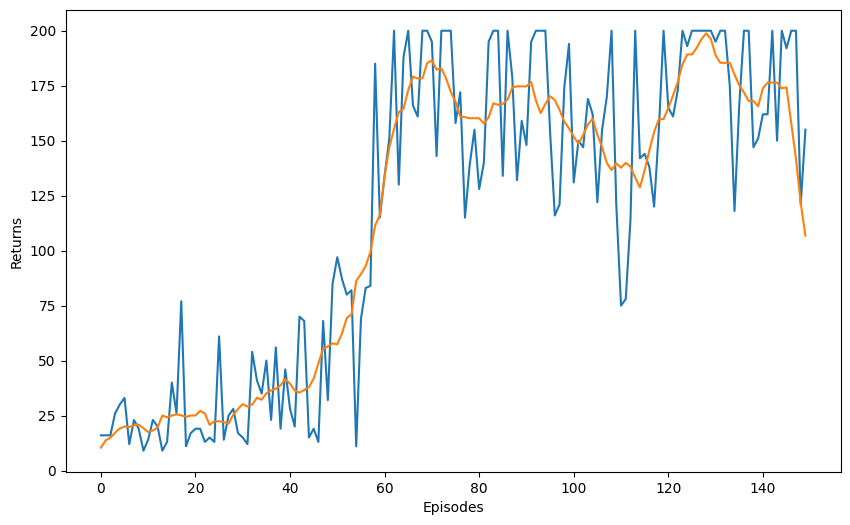

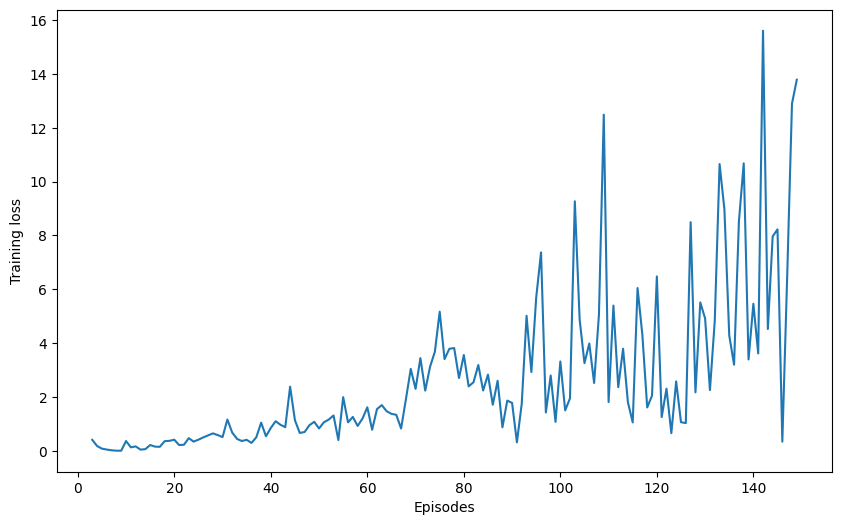

In [ ]:
# Parameters
nb_episodes = 150
batch_size = 32

epsilon = 1.0
epsilon_decay = 0.0005

gamma = 0.99

learning_rate = 0.005
buffer_limit = 5000
target_update_period = 100
training_update_period = 4

# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
agent = DQNAgent(env, create_model, learning_rate, epsilon, epsilon_decay, gamma, batch_size, target_update_period, training_update_period, buffer_limit)

# Train the agent
returns, losses = agent.train(nb_episodes)

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 10))
plt.xlabel("Episodes")
plt.ylabel("Returns")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Training loss")
plt.show()


  f"The environment {id} is out of date. You should consider "



Number of steps: 200
MoviePy - Building file videos/cartpole-dqn.gif with imageio.



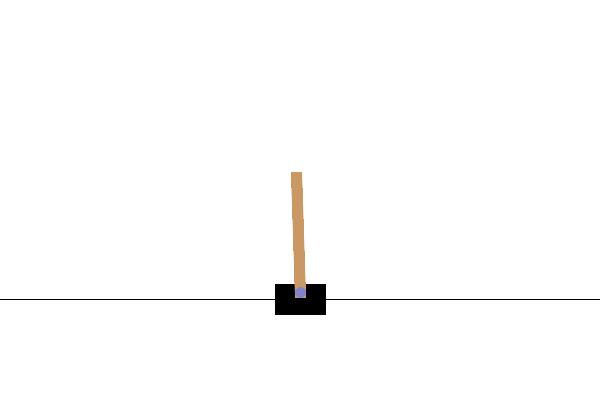

In [ ]:
# Test the network
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)
agent.env = env

nb_steps = agent.test()
recorder.record(env.render())
print("Number of steps:", nb_steps)

video = "videos/cartpole-dqn.gif"
recorder.make_video(video)
ipython_display(video, loop=0, autoplay=1)